In [16]:
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import numpy.linalg as la
from mpl_toolkits import mplot3d
from pauli import *
from qm_tools import sort_eigensystem, plot_spectrum
from tqdm.notebook import tqdm

plt.style.use("../plot_style.mplstyle")

# Define TRIM points
trim_def = {
    "G": np.array((0, 0)),
    "X": np.array((np.pi, 0)),
    "-X": np.array((-np.pi, 0)),
    "Y": np.array((0, np.pi)),    
    "-Y": np.array((0, -np.pi)),
    "M": np.array((np.pi, np.pi)),
    "-M": np.array((-np.pi, -np.pi))
}

def generate_k_path(path, num_points=100):
    """
    Generate a path in k-space connecting the given TRIM points.
    
    Parameters:
    - path: List of TRIM point labels to connect.
    - num_points: Number of points to generate between each pair of TRIM points.
    
    Returns:
    - kx_array: Array of kx points along the path.
    - ky_array: Array of ky points along the path.
    - t_array: Array of points representing the relative positions along the path.
    """
    kx_array = []
    ky_array = []
    t_array = []

    for i in range(len(path)-1):
        start_point = trim_def[path[i]]
        end_point = trim_def[path[i + 1]]
        segment = np.linspace(start_point, end_point, num_points, endpoint=False)
        t = np.linspace(i, i+1, num_points, endpoint=False)
        
        kx_array.extend(segment[:, 0])
        ky_array.extend(segment[:, 1])
        t_array.extend(t)
    
    # Append the last point
    kx_array.append(trim_def[path[-1]][0])
    ky_array.append(trim_def[path[-1]][1])
    t_array.append(len(path)-1)
    
    return np.array(kx_array), np.array(ky_array), np.array(t_array)

def H_n(kx, ky, mu, az, eta, hx, hy, hz):
    H = np.zeros((2, 2), dtype=complex)

    H += np.kron(s0, 2*(2 - np.cos(kx) - np.cos(ky)) - mu)

    H += np.kron(sy, +az * np.sin(kx))
    H += np.kron(sx, -az * np.sin(ky))
    
    H += np.kron(sx, hx)
    H += np.kron(sy, hy)
    H += np.kron(sz, hz)

    H += np.kron(sz, 2*eta*(np.cos(kx) - np.cos(ky)))

    return H

In [17]:
mu, az, eta, hx, hy, hz = (1, 0.05, 0.25, 0, 0, 0)

In [18]:
path = ["-X", "G", "X", "M", "Y", "G", "-Y"]
kx_array, ky_array, t_array = generate_k_path(path, 100)

ws, vs = [], []

for kx, ky in zip(kx_array, ky_array):
    H = H_n(kx, ky, mu, az, eta, hx, hy, hz)
    eigvals, eigvecs = la.eigh(H)
    ws.append(eigvals)
    vs.append(eigvecs)

ws = np.array(ws)
vs = np.array(vs)
ws, vs = sort_eigensystem(ws, vs)
szs = np.einsum("nmi, ij, nmj -> nm", vs, sz, vs.conj()).real

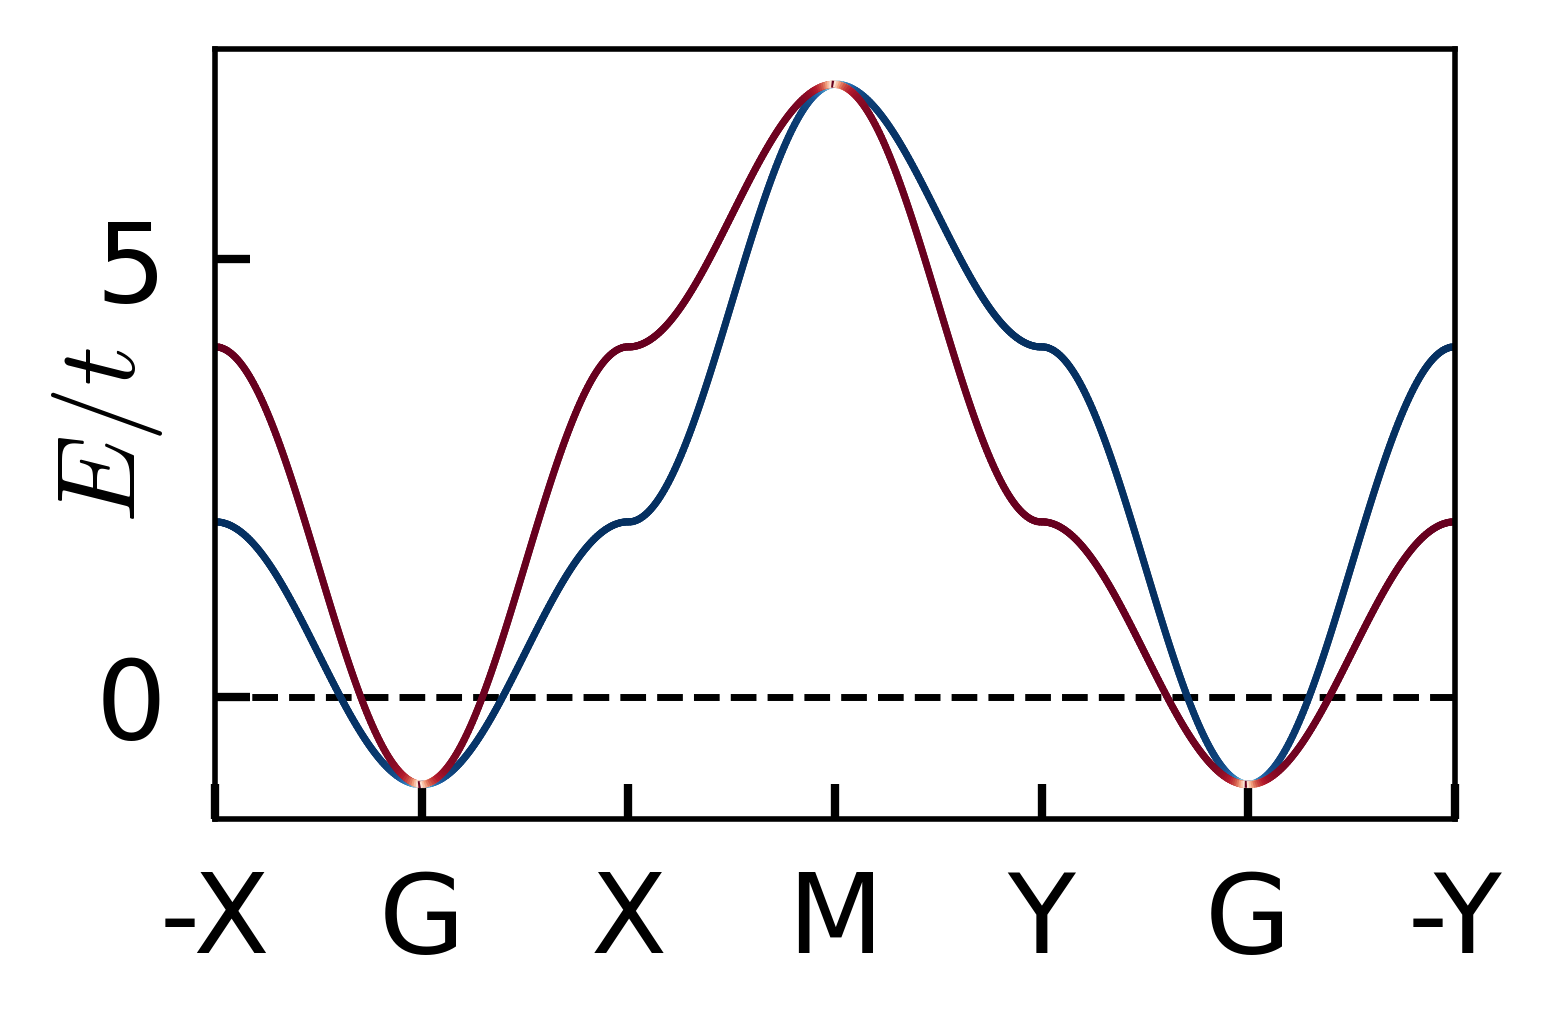

In [34]:
# Plotting the band structure with colormap
fig, ax = plt.subplots(figsize=(1.6, 1))

# Normalize the sz values for colormap
norm = mpl.colors.Normalize(vmin=-1, vmax=+1)
cmap = plt.get_cmap('RdBu')
sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
sm.set_array([])

ax.hlines([0], 0, 6, linestyles='--', colors='k')

for i in range(ws.shape[1]):
    colors = cmap(norm(szs[:, i]))
    for j in range(len(ws) - 1):
        ax.plot(t_array[j:j+2], ws[j:j+2, i], '-', color=colors[j])

# # Add a colorbar to the plot
# cbar = plt.colorbar(sm, ax=ax)
# cbar.set_label('Sz value')

ax.set_xlim(0, 6)
ax.set_xticks(np.arange(len(path)))
ax.set_xticklabels(path)

ax.set_ylabel(r"$E / t$", labelpad=-5)

fig.savefig("Fig1a.svg")

In [20]:
tolerance = 5e-3

# Create a meshgrid of kx, ky points
kx_vals = np.linspace(-np.pi, np.pi, 1200)
ky_vals = np.linspace(-np.pi, np.pi, 1200)
kx_grid, ky_grid = np.meshgrid(kx_vals, ky_vals)

# Lists to store the kx, ky points where ws is approximately zero and their sz values
zero_kx = []
zero_ky = []
sz_values = []

# Diagonalize the Hamiltonian at each point and check for zero eigenvalues
for i, kx in enumerate(kx_vals): 
    for j, ky in enumerate(ky_vals):
        H = H_n(kx, ky, mu, az, eta, hx, hy, hz)

        eigvals, eigvecs = la.eigh(H)
        for n in range(2):
            if (np.abs(eigvals[n]) < tolerance):
                zero_kx.append(kx)
                zero_ky.append(ky)
                sz_val = np.einsum("i, ij, j", eigvecs[:, n], sz, eigvecs[:, n].conj()).real
                sz_values.append(sz_val)

# Convert lists to arrays for plotting
zero_kx = np.array(zero_kx)
zero_ky = np.array(zero_ky)
sz_values = np.array(sz_values)

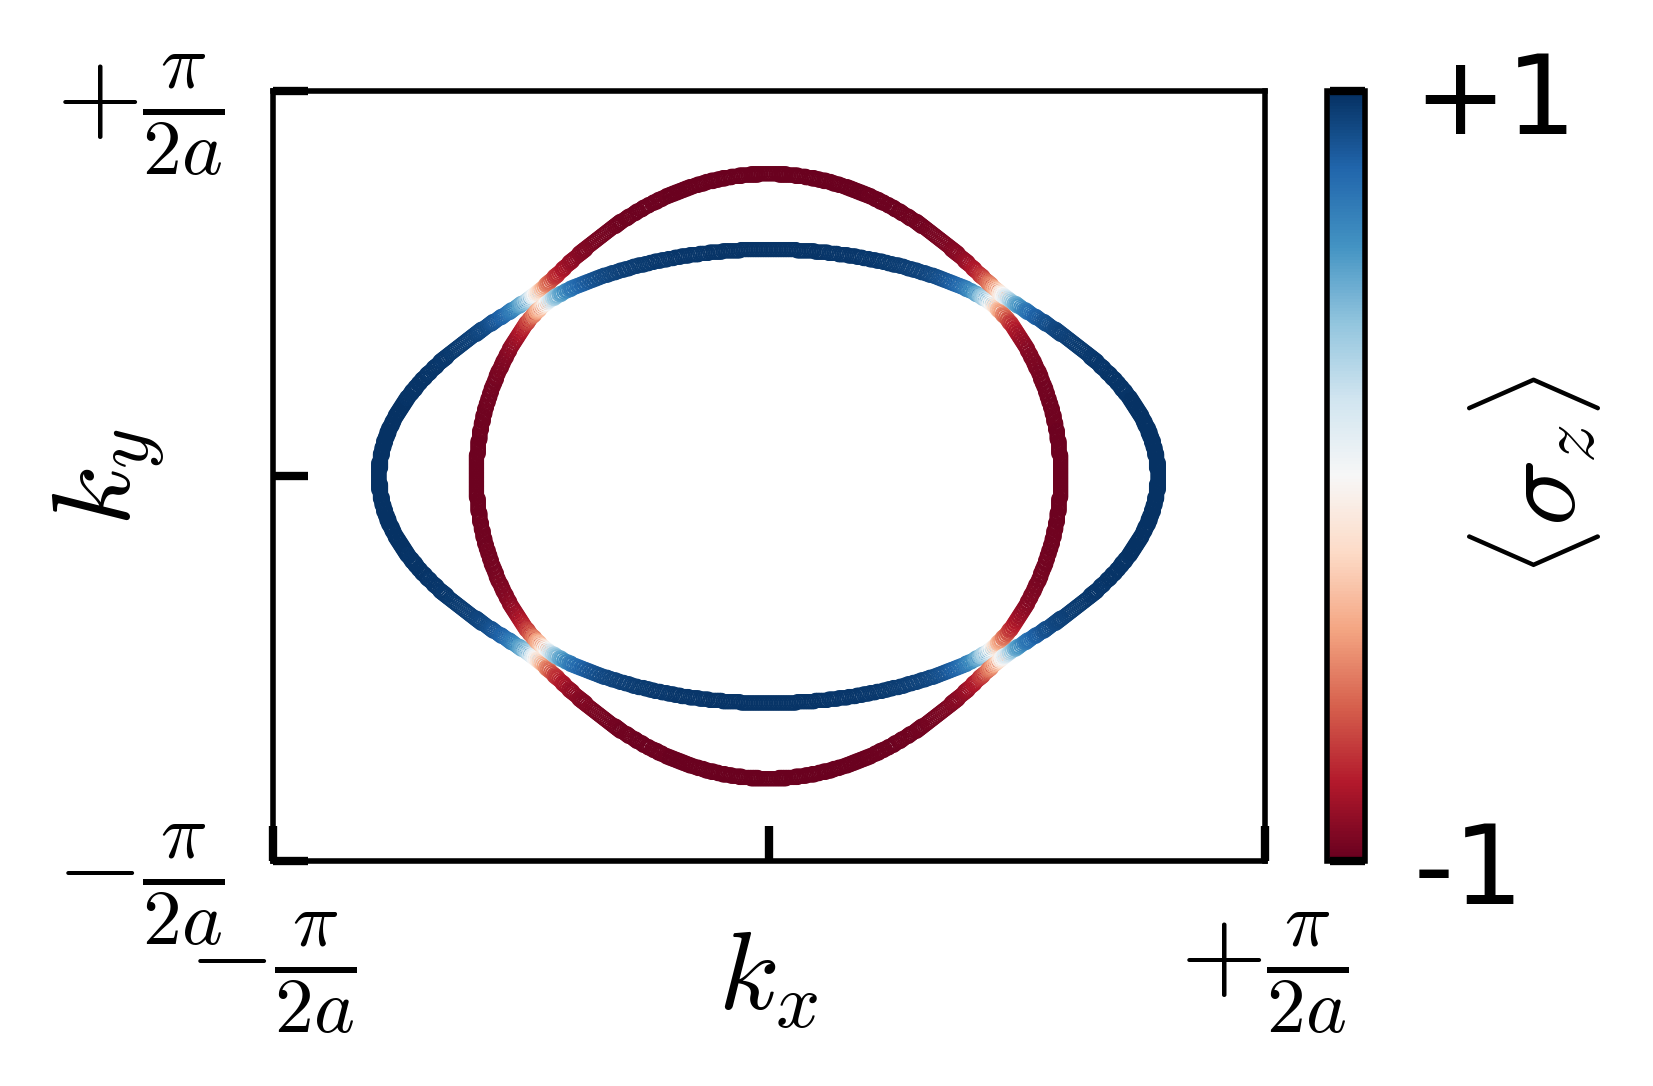

In [22]:
# Plot the points where ws is approximately zero with color based on sz values
fig, ax = plt.subplots(figsize=(1.6, 1))
scatter = ax.scatter(zero_kx, zero_ky, c=sz_values, cmap=cmap, s=0.01, vmin=-1, vmax=1, alpha=1)
ax.set_xticks([-np.pi/2, 0, np.pi/2], labels=[r"$-\frac{\pi}{2a}$", "", r"$+\frac{\pi}{2a}$"])
ax.set_yticks([-np.pi/2, 0, np.pi/2], labels=[r"$-\frac{\pi}{2a}$", "", r"$+\frac{\pi}{2a}$"])
ax.set_xlabel(r'$k_x$', labelpad=-8)
ax.set_ylabel(r'$k_y$', labelpad=-8)

cbar = fig.colorbar(scatter)
cbar.set_label(r'$\langle \sigma_z \rangle$', labelpad=-8)
cbar.set_ticks([-1, +1], labels=["-1", "+1"])

fig.savefig("Fig1b.svg")